In [51]:
from PIL import Image
import scipy as sp
import scipy.ndimage
import scipy.io.wavfile
import numpy as np
import math, wave, struct
import matplotlib.pyplot as plt
import IPython.display

In [33]:
def pltMat(mat):
    mat = np.flip(mat,0)
    X, Y = np.meshgrid(range(mat.shape[0]), range(mat.shape[1]))
    Z = mat[X, Y]
    plt.pcolormesh(Y,X,Z)
    plt.show()

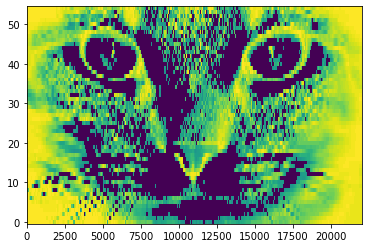

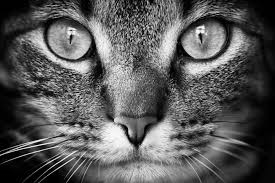

In [86]:
def image_thingy(file, size=(0,0)):
    img = Image.open(file)
    
    img = img.convert("L")

    imgArr = np.array(img)
        
    #aumentar contraste
    imgArr = imgArr/np.max(imgArr)
    imgArr = 1/(imgArr+10**14)
    
    #normalize
    imgArr -= np.min(imgArr)
    imgArr /= np.max(imgArr)
    
    removeLow = np.vectorize(lambda x: x if x > .5 else 0, otypes=[float])
    imgArr = removeLow(imgArr)
    
    #imgArr = 1/imgArr #testar depois TODO
    if size == (0,0): size = imgArr.shape
    
    resamplingFactor = size[0]/imgArr.shape[0], size[1]/imgArr.shape[1]
    imgArr = sp.ndimage.zoom(imgArr, resamplingFactor, order=0)
    
    pltMat(imgArr)
    display(img)
    return imgArr
image_thingy("image.jpg", size=(55,22050))
print()

In [56]:
def pltSpec(file):
    sample_rate, X = scipy.io.wavfile.read(file)
    plt.specgram(X, Fs=sample_rate)

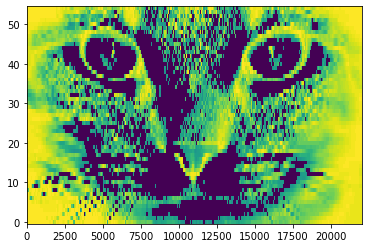

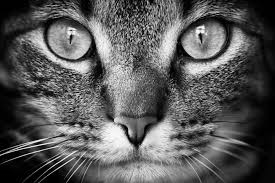

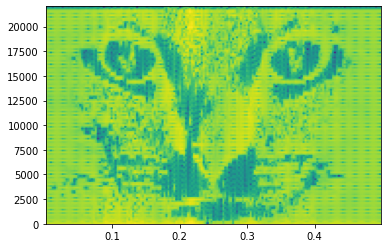

In [98]:
def genSound(file):
    sample_rate = 44100
    duration = .5
    
    wavef = wave.open("sound.wav", "w")
    wavef.setnchannels(1)
    wavef.setsampwidth(2)
    wavef.setframerate(sample_rate)
    
    max_frame = int(duration*sample_rate)
    max_freq = 22000
    max_intensity = 32767 #int16
    
    stepSize = 400
    steppingSepctrum = int(max_freq/stepSize)
    
    #print(steppingSepctrum, max_frame)
    imgMat = image_thingy(file, (steppingSepctrum, max_frame))

    imgMat *= max_intensity
    for frame in range(max_frame):
        signalValue, count = 0, 0
        for step in range(steppingSepctrum):
            intensity = imgMat[step, frame]
            if intensity == 0:
                continue
            currentFreq = max_freq - step * stepSize
            nextFreq = max_freq - (step+1)*stepSize
            if nextFreq < 0: #end of spectrum
                nextFreq = 0
            for freq in range(nextFreq, currentFreq, 500):
                signalValue += intensity*math.cos(freq * 2 * math.pi * float(frame)/float(sample_rate))
                count += 1
        if count == 0: count = 1
        signalValue /= count
        data = struct.pack("<h", int(signalValue))
        wavef.writeframesraw( data )
    wavef.writeframes(''.encode())
    wavef.close()
    pltSpec("sound.wav")
genSound("image.jpg")